<a href="https://colab.research.google.com/github/dbejarano31/Master-Thesis-Information-Management/blob/main/BERT_HF_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT
<br> </br>

Here we are going to try another implementation of BERT, using the HuggingFace API [see here](https://huggingface.co/transformers/main_classes/trainer.html).
<br></br>
To download our dataset, [see here](https://drive.google.com/file/d/1o1BMTTU9YNPATL8x93l0N-h6sTZxLyDo/view?usp=sharing).

## Imports

In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-utsvydsl
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-utsvydsl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2178482 sha256=615f457aad392146f0c2d5a0f1b3e9926ad815d268d23ba1b479f348fcf69fcb
  Stored in directory: /tmp/pip-ephem-wheel-cache-umbta3wc/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers


In [ ]:
#!pip install transformers
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import math
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns

import os

from transformers.utils import *
from transformers.data.data_collator import DataCollator, DataCollatorWithPadding, default_data_collator
from transformers.file_utils import (
    WEIGHTS_NAME,
    is_apex_available,
    is_datasets_available,
    is_in_notebook,
    is_sagemaker_dp_enabled,
    is_sagemaker_mp_enabled,
    is_torch_tpu_available,
    is_training_run_on_sagemaker,
)
from transformers.modeling_utils import PreTrainedModel, unwrap_model
from transformers.optimization import Adafactor, AdamW, get_scheduler
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.trainer_callback import (
    CallbackHandler,
    DefaultFlowCallback,
    PrinterCallback,
    ProgressCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from transformers.trainer_utils import (
    PREFIX_CHECKPOINT_DIR,
    BestRun,
    EvalPrediction,
    HPSearchBackend,
    PredictionOutput,
    ShardedDDPOption,
    TrainerMemoryTracker,
    TrainOutput,
    default_compute_objective,
    default_hp_space,
    denumpify_detensorize,
    get_last_checkpoint,
    set_seed,
    speed_metrics,
)
from transformers.training_args import ParallelMode, TrainingArguments
from transformers.utils import logging
from transformers.utils.modeling_auto_mapping import MODEL_FOR_QUESTION_ANSWERING_MAPPING_NAMES 
import torch
import tensorflow as tf
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback
import tensorflow_hub as hub

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split



from torch.utils.data.dataset import Dataset


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Connecting to cloud hardware

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available
We will use the GPU: Tesla P100-PCIE-16GB


## Importing data

In [ ]:
df = pd.read_csv('/content/final_consolidated_data')
df.head()

,Unnamed: 0,CIK Code,Filing,Date Filed,Ticker,CompanyName,PrevAvgPriceChange,PostAvgPriceChange,Label
0,0,1680378,Investing in ourshares of common stock involve...,2021-03-18,SNES,"SenesTech, Inc.",0.001328,-0.003177,decrease
1,1,1222719,Investing in any of our securities involves ri...,2021-01-31,CHY,CALAMOS CONVERTIBLE & HIGH INCOME FUND,0.004126,0.006552,neutral
2,2,1364954,An investment in our securities involves a hig...,2021-04-03,CHGG,"CHEGG, INC",0.065078,0.011987,neutral
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",0.412805,0.058477,neutral
4,4,1409375,Investing in our common stock involves a high ...,2021-03-10,OESX,"ORION ENERGY SYSTEMS, INC.",-0.046603,-0.002521,neutral


In [ ]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1349
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIK Code            1350 non-null   int64  
 1   Filing              1350 non-null   object 
 2   Date Filed          1350 non-null   object 
 3   Ticker              1350 non-null   object 
 4   CompanyName         1350 non-null   object 
 5   PrevAvgPriceChange  1350 non-null   float64
 6   PostAvgPriceChange  1350 non-null   float64
 7   Label               1350 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 94.9+ KB


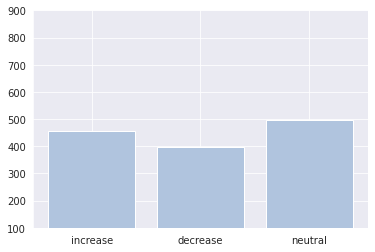

In [ ]:
incr_counts = 0
decr_counts = 0
neutral_counts = 0

for i in df.Label:
  if i == 'increase':
    incr_counts += 1
  elif i == 'decrease':
    decr_counts += 1

neutral_counts = len(df) - (incr_counts + decr_counts)

counts = [incr_counts, decr_counts, neutral_counts]
labs = ['increase', 'decrease', 'neutral']

sns.set_style('darkgrid')
color = 'lightsteelblue'

plt.bar(labs, counts, color = color)
plt.ylim([100, 900])
plt.show()

## Model import and configuration

In [ ]:
# importing model
bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
                                                          num_labels = 3)
config = bert.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#changing labels
config.max_position_embeddings = 300
config.id2label[0] = 'decrease'
config.id2label[1] = 'neutral'
config.id2label[2] = 'increase'
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "decrease",
    "1": "neutral",
    "2": "increase"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 300,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
config.label2id['decrease'] = config.label2id['LABEL_0']
config.label2id['neutral'] = config.label2id['LABEL_1']
config.label2id['increase'] = config.label2id['LABEL_2']
del config.label2id['LABEL_0']
del config.label2id['LABEL_1']
del config.label2id['LABEL_2']
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "decrease",
    "1": "neutral",
    "2": "increase"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "decrease": 0,
    "increase": 2,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 300,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
config.hidden_dropout_prob = 0.3

In [ ]:
# importing tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast = True)

In [ ]:
tokenizer.model_max_length = 300
tokenizer.model_max_length

300

TUNE PARAMETERS HERE !

In [ ]:
batch_size = 32
epochs = 10
lr = 1e-5
early_stopping = early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)
auto = tf.data.experimental.AUTOTUNE
max_seq_length = 300

## Data pre-processing

BERT's word embeddings are really good, and they do really well processing completely unstructured and unprocessed data. But in order to minimize the amount of data to be used (we have to spare our GPU memory) we are going to remove stop words. 

In [ ]:
# Stop word removal
def remove_stopwords(text):
  filtered = []
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  for w in word_tokens:
    if w not in stop_words:
      filtered.append(w)
  filtered_doc = ' '.join(str(i) for i in filtered)
  return filtered_doc

In [ ]:
df['Filing'] = df['Filing'].apply(lambda x: remove_stopwords(x))

In [ ]:
#train/test splitting
x = df.Filing.values
y = df.Label.values
labs = []

for i in y:
  if i == 'decrease':
    labs.append(0)
  elif i == 'neutral':
    labs.append(1)
  else:
    labs.append(2)
labs = np.array(labs)
x_train, x_test, y_train, y_test = train_test_split(x, labs, test_size = 0.3, random_state = 42)

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(x_train, y_train, test_size =0.2)

In [ ]:
train_encodings = tokenizer(list(train_texts),
                            truncation = True,
                            padding = True,
                            return_overflowing_tokens = True,
                            return_offsets_mapping = True,
                            stride = 100,
                            max_length = max_seq_length,
                            return_tensors = 'pt')

val_encodings = tokenizer(list(val_texts),
                          truncation = True,
                          padding = True,
                          return_overflowing_tokens = True,
                          return_offsets_mapping = True,
                          stride = 100,
                          max_length = max_seq_length,
                          return_tensors = 'pt')

test_encodings = tokenizer(list(x_test),
                           truncation = True,
                           padding = True,
                           return_overflowing_tokens = True, 
                           return_offsets_mapping = True,
                           stride = 100, 
                           max_length = max_seq_length,
                           return_tensors = 'pt')

The cell above tokenizes and splits the filings into the sub-filings of length 300, with a 100 token overlap with its neighboring sub-filings. Now we have to map each window to its respective label. For this we use the offsets mapping that was returned. 

In [ ]:
train_sub_labs = []
val_sub_labs = []
test_sub_labs = []

for idx, lab in enumerate(train_labels):
  for i in train_encodings['overflow_to_sample_mapping']:
    if i == idx:
      train_sub_labs.append(lab)

for idx, lab in enumerate(val_labels):
  for i in val_encodings['overflow_to_sample_mapping']:
    if i == idx:
      val_sub_labs.append(lab)

for idx, lab in enumerate(y_test):
  for i in test_encodings['overflow_to_sample_mapping']:
    if i == idx:
      test_sub_labs.append(lab)

train_sub_labs = np.array(train_sub_labs)
val_sub_labs = np.array(val_sub_labs)
test_sub_labs = np.array(test_sub_labs)

Now that we have each window mapped with their label, we have to make sure that our inputs are correct. We actually used the overflowing tokens and offsets mapping for the steps above, but BERT does not recognize them as input, so we need to take them out. 

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
train_encodings.keys

<bound method BatchEncoding.keys of {'input_ids': tensor([[  101,  8875, 20720,  ...,  6855,  3176,   102],
        [  101,  4598,  7790,  ...,  3325,  4022,   102],
        [  101,  2256,  4945,  ...,  1012,  2256,   102],
        ...,
        [  101,  6226,  1012,  ...,  7080,  4295,   102],
        [  101,  1011,  1057,  ...,  8875, 20720,   102],
        [  101,  3795,  4425,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'offset_mapping': tensor([[[     0,      0],
         [     0,      4],
         [     5,      7],
         ...,


In [ ]:
train_encodings.pop('overflow_to_sample_mapping')
train_encodings.pop('offset_mapping')
test_encodings.pop('overflow_to_sample_mapping')
test_encodings.pop('offset_mapping')
val_encodings.pop('overflow_to_sample_mapping')
val_encodings.pop('offset_mapping')
train_encodings.keys

<bound method BatchEncoding.keys of {'input_ids': tensor([[  101,  8875, 20720,  ...,  6855,  3176,   102],
        [  101,  4598,  7790,  ...,  3325,  4022,   102],
        [  101,  2256,  4945,  ...,  1012,  2256,   102],
        ...,
        [  101,  6226,  1012,  ...,  7080,  4295,   102],
        [  101,  1011,  1057,  ...,  8875, 20720,   102],
        [  101,  3795,  4425,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}>

Now that inputs are ready, we can create the PyTorch datasets with the encodings and the labels. 

In [ ]:
class SEC_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SEC_Dataset(train_encodings, train_sub_labs)
val_dataset = SEC_Dataset(val_encodings, val_sub_labs)
test_dataset = SEC_Dataset(test_encodings, test_sub_labs)

## Performance metrics

In [ ]:
# custom metrics
def compute_metrics(eval_pred):
  labels = eval_pred.label_ids
  preds = eval_pred.predictions.argmax(-1)
  lab_names = [0,1,2]
  
  precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average ='weighted')
  acc = accuracy_score(labels, preds)
  print(precision_recall_fscore_support(labels, preds, average = None, labels = lab_names))

  dic = {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall,
      'Support': support
  }
  return dic

## Training

In [ ]:
# overriding trainer class to log metrics during training --> evaluate overfitting
class MyTrainer(Trainer):
  def __init__(self, model,
        args = None,
        data_collator = None,
        train_dataset = None,
        eval_dataset = None,
        tokenizer = None,
        model_init = None,
        compute_metrics = None,
        callbacks = None,
        optimizers = (None,None)
    ):

    super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init,
                  compute_metrics, callbacks, optimizers) 
    
  def evaluate(
        self,
        train_dataset = None,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> Dict[str, float]:
        
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        if eval_dataset is not None and not isinstance(eval_dataset, collections.abc.Sized):
            raise ValueError("eval_dataset must implement __len__")

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        train_output = self.prediction_loop(
            train_dataloader,
            description = 'Training',
            prediction_loss_only = True if self.compute_metrics is None else None,
            ignore_keys = ignore_keys,
            metric_key_prefix = 'train',
            )


        eval_output = self.prediction_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )
        train_n_samples = len(self.train_dataset)
        train_output.metrics.update(speed_metrics('train', start_time, train_n_samples))
        self.log(train_output.metrics)

        eval_n_samples = len(eval_dataset if eval_dataset is not None else self.eval_dataset)
        eval_output.metrics.update(speed_metrics(metric_key_prefix, start_time, eval_n_samples))
        self.log(eval_output.metrics)

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())
        
        train_output.metrics['eval_loss'] = 'No log'
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, eval_output.metrics)
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, train_output.metrics)

        self._memory_tracker.stop_and_update_metrics(train_output.metrics)
        self._memory_tracker.stop_and_update_metrics(eval_output.metrics)

        dic = {
        'Training metrics': train_output.metrics,
        'Validation metrics': eval_output.metrics
        }

        return dic



<b>NOTE</b> below two rows per epoch are reported since it prints one row for the evaluation, and one row for training. That's why there is no log in the second row for validation loss, and why the training loss is the same for the two rows. 

In [ ]:
training_args = TrainingArguments(
    output_dir = 'BERT',
    num_train_epochs = epochs,
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'epoch',
    logging_strategy = 'epoch',
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    warmup_steps = 250,
    weight_decay = 0.2,
    gradient_accumulation_steps = 3,
    learning_rate = 1e-5,
    fp16 = True 
)

trainer = MyTrainer(
    model = bert,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Support
1,1.043200,1.065484,0.459409,0.441004,0.452141,0.459409,None
1,1.043200,No log,0.556718,0.548049,0.566872,0.556718,None
2,0.846400,1.075785,0.505265,0.484164,0.509036,0.505265,None
2,0.846400,No log,0.710893,0.703463,0.726439,0.710893,None
3,0.651200,0.996068,0.570652,0.563971,0.566603,0.570652,None
3,0.651200,No log,0.805249,0.804922,0.808433,0.805249,None
4,0.529800,0.988709,0.592221,0.590958,0.594767,0.592221,None
4,0.529800,No log,0.839143,0.839659,0.846169,0.839143,None
5,0.450200,1.038999,0.605639,0.600970,0.602100,0.605639,None
5,0.450200,No log,0.878794,0.878524,0.878640,0.878794,None


/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.51365751, 0.59484385, 0.59856115]), array([0.68687097, 0.57936103, 0.33537569]), array([0.58776853, 0.58700036, 0.4298853 ]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.50368236, 0.40789474, 0.41374474]), array([0.59969501, 0.49821429, 0.18611987]), array([0.54751131, 0.44855305, 0.256745  ]), array([2623, 1680, 1585]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.68699229, 0.69335517, 0.83494593]), array([0.75551284, 0.82116975, 0.4730732 ]), array([0.71962516, 0.75186916, 0.60395224]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.55397924, 0.44739057, 0.5       ]), array([0.61036981, 0.6327381 , 0.19621451]), array([0.580809  , 0.52416174, 0.28183054]), array([2623, 1680, 1585]))
(array([0.75837031, 0.84047469, 0.82920059]), array([0.85039014, 0.81688272, 0.72250887]), array([0.80174849, 0.82851079, 0.7721868 ]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.59337748, 0.55426582, 0.53537118]), array([0.68318719, 0.56845238, 0.38675079]), array([0.63512316, 0.56126947, 0.44908425]), array([2623, 1680, 1585]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.82535631, 0.91612213, 0.76534245]), array([0.87753025, 0.78707768, 0.86665592]), array([0.85064401, 0.84671132, 0.81285444]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.61990325, 0.64956012, 0.49509202]), array([0.68394968, 0.52738095, 0.50914826]), array([0.65035345, 0.58212878, 0.50202177]), array([2623, 1680, 1585]))
(array([0.87702703, 0.88487921, 0.8710825 ]), array([0.8806966 , 0.90854343, 0.82908739]), array([0.87885798, 0.8965552 , 0.84956629]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.63866145, 0.58833063, 0.55618893]), array([0.68394968, 0.64821429, 0.43091483]), array([0.66053019, 0.61682243, 0.48560256]), array([2623, 1680, 1585]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.9002983 , 0.88458175, 0.89130807]), array([0.88736854, 0.92936613, 0.83827797]), array([0.89378666, 0.90642111, 0.86398006]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.65354623, 0.5622276 , 0.59292035]), array([0.67098742, 0.69107143, 0.42271293]), array([0.66215199, 0.6200267 , 0.49355433]), array([2623, 1680, 1585]))
(array([0.90387213, 0.91446834, 0.88774172]), array([0.90806287, 0.9199755 , 0.87342793]), array([0.90596266, 0.91721366, 0.88052666]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.64807624, 0.59675676, 0.58257261]), array([0.69996188, 0.65714286, 0.44290221]), array([0.67302053, 0.62549575, 0.50322581]), array([2623, 1680, 1585]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.91300387, 0.92500259, 0.8701705 ]), array([0.90670587, 0.91272839, 0.89696872]), array([0.90984397, 0.9188245 , 0.88336642]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.65398551, 0.62868949, 0.5446304 ]), array([0.68814335, 0.63392857, 0.49274448]), array([0.67062976, 0.63129816, 0.51738986]), array([2623, 1680, 1585]))
(array([0.90212251, 0.9282099 , 0.90210943]), array([0.92762637, 0.91721956, 0.88261851]), array([0.9146967 , 0.922682  , 0.89225754]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.64414875, 0.62514484, 0.57839155]), array([0.7197865 , 0.6422619 , 0.44921136]), array([0.67987036, 0.63358779, 0.50568182]), array([2623, 1680, 1585]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:368: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


(array([0.91067053, 0.92190187, 0.91169092]), array([0.92457311, 0.93018271, 0.87891003]), array([0.91756916, 0.92602378, 0.89500041]), array([8843, 9797, 6202]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.65117892, 0.60967565, 0.58987342]), array([0.71597408, 0.66011905, 0.44100946]), array([0.68204104, 0.6338954 , 0.50469314]), array([2623, 1680, 1585]))


TrainOutput(global_step=2590, training_loss=0.5133533669254494, metrics={'train_runtime': 10702.8138, 'train_samples_per_second': 0.242, 'total_flos': 1698368086882800.0, 'epoch': 10.0, 'init_mem_cpu_alloc_delta': 61440, 'init_mem_gpu_alloc_delta': 439355904, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -1972228096, 'train_mem_gpu_alloc_delta': 1341046784, 'train_mem_cpu_peaked_delta': 1972477952, 'train_mem_gpu_peaked_delta': 9656779776})

In [ ]:
trainer.state.log_history

[{'epoch': 1.0,
  'learning_rate': 9.961538461538463e-06,
  'loss': 1.0432,
  'step': 259},
 {'epoch': 1.0,
  'step': 259,
  'train_Accuracy': 0.5567184606714435,
  'train_F1': 0.5480487990543723,
  'train_Precision': 0.5668720215576611,
  'train_Recall': 0.5567184606714435,
  'train_Support': None,
  'train_loss': 0.9318682551383972,
  'train_runtime': 299.4548,
  'train_samples_per_second': 82.957},
 {'epoch': 1.0,
  'eval_Accuracy': 0.4594089673913043,
  'eval_F1': 0.44100409678688807,
  'eval_Precision': 0.4521412013052532,
  'eval_Recall': 0.4594089673913043,
  'eval_Support': None,
  'eval_loss': 1.0654839277267456,
  'eval_runtime': 299.4627,
  'eval_samples_per_second': 19.662,
  'step': 259},
 {'epoch': 2.0,
  'learning_rate': 8.854700854700855e-06,
  'loss': 0.8464,
  'step': 518},
 {'epoch': 2.0,
  'step': 518,
  'train_Accuracy': 0.710892842766283,
  'train_F1': 0.7034626547316261,
  'train_Precision': 0.7264394184135554,
  'train_Recall': 0.710892842766283,
  'train_Suppor

## Plotting training

In [ ]:
for log_history in trainer.state.log_history:
  print(log_history.keys())

dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_Support', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_Support', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_Support', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_Support', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_Support', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict

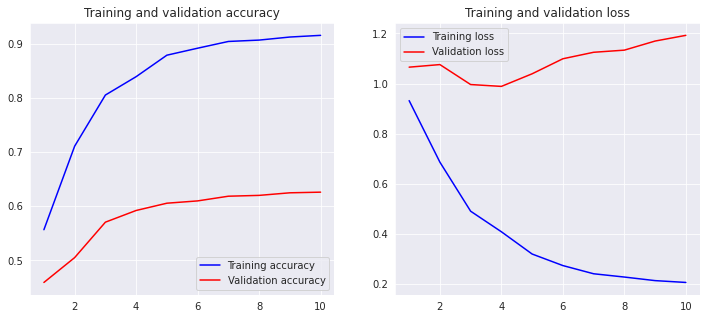

In [ ]:
sns.set_style('darkgrid')
train_loss = []
eval_loss = []
eval_acc = []
train_acc = []

for log_history in trainer.state.log_history:

  if 'train_loss' in log_history.keys():
    train_loss.append(log_history['train_loss'])
    train_acc.append(log_history['train_Accuracy'])
    
  elif 'eval_loss' in log_history.keys():
    eval_loss.append(log_history['eval_loss'])
    eval_acc.append(log_history['eval_Accuracy'])

x = range(1, len(train_acc) + 1)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(x, train_acc, 'b', label = 'Training accuracy')
plt.plot(x, eval_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x, train_loss, 'b', label = 'Training loss')
plt.plot(x, eval_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
print(eval_loss, eval_acc)

[1.0654839277267456, 1.0757845640182495, 0.9960682988166809, 0.9887093305587769, 1.038999319076538, 1.0990045070648193, 1.1249126195907593, 1.1334296464920044, 1.1697031259536743, 1.1924821138381958] [0.4594089673913043, 0.505264945652174, 0.5706521739130435, 0.5922214673913043, 0.6056385869565217, 0.6098845108695652, 0.618546195652174, 0.6200747282608695, 0.6248301630434783, 0.6260190217391305]


In [ ]:
trainer.predict(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


(array([0.55444423, 0.61829475, 0.53708958]), array([0.57506361, 0.6792804 , 0.42278239]), array([0.56456572, 0.64735442, 0.4731298 ]), array([5109, 4836, 3134]))


PredictionOutput(predictions=array([[ 1.1682962 ,  1.8538942 , -2.420154  ],
       [ 1.6199521 ,  1.3385397 , -2.4182038 ],
       [-2.1470115 ,  3.0189173 , -1.3297758 ],
       ...,
       [ 2.1409113 , -2.7389429 ,  0.82145435],
       [ 1.9699595 , -2.33028   ,  0.6156627 ],
       [ 3.1488488 , -2.4010017 , -0.01001421]], dtype=float32), label_ids=array([1, 1, 1, ..., 2, 2, 2]), metrics={'test_loss': 1.4325487613677979, 'test_Accuracy': 0.5771083416163315, 'test_F1': 0.5732671469893497, 'test_Precision': 0.573894621283847, 'test_Recall': 0.5771083416163315, 'test_Support': None, 'test_runtime': 131.1943, 'test_samples_per_second': 99.692, 'test_mem_cpu_alloc_delta': 413696, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 0, 'test_mem_gpu_peaked_delta': 799074304})